In [1]:
import numpy as np
from astropy.table import Table, join, MaskedColumn, vstack
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from math import e
from math import pi
from astropy.table import Column
from math import sqrt
import numpy as np
import emcee
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import math
import corner
from numpy import exp
from scipy import integrate
from scipy.integrate import quad
import pdb
import powerlaw
import random

In [5]:
#Reading in data file
M51_raw=Table.read('M51_Messa_2018_CSV.csv')
M51_raw

#Messa+ 2018 only used masses greater than 5000 solar masses
M51_used_masses_ind=np.where(M51_raw['Best_Mass_Msolar']>5000)
M51_used_masses=M51_raw[M51_used_masses_ind]
M51_used_masses

#Only used Ages Less than 200 Myr
M51_age_cut=np.where(M51_used_masses['Best_Age_yr']<200000000)
M51_used_ages_masses=M51_used_masses[M51_age_cut]
M51_used_ages_masses

log_masses=np.log10(M51_used_ages_masses['Best_Mass_Msolar'])
log_max_mass=np.log10(M51_used_ages_masses['Max_Mass_Msolar'])
log_min_mass=np.log10(M51_used_ages_masses['Min_Mass_Msolar'])

#20 Clusters with no upper or lower Estimates
no_max_min_estimate=np.where(log_max_mass<0)
M51_used_ages_masses.remove_rows([no_max_min_estimate])
M51_use=M51_used_ages_masses
M51_use

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/astropy/table/table.py:2226: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  keep_mask[row_specifier] = False


ID,X_inrf,Y_inrf,RA,DEC,F275W_MAG,F275W_ERR,F336W_MAG,F336W_ERR,F435W_MAG,F435W_ERR,F555W_MAG,F555W_ERR,F814W_MAG,F814W_ERR,CI,Best_Age_yr,Max_Age_yr,Min_Age_yr,Best_Mass_Msolar,Max_Mass_Msolar,Min_Mass_Msolar,Best_E(B-V),Max_E(B-V),Min_E(B-V),Chi2_residual_F275W,Chi2_residual_F336W,Chi2_residual_F435W,Chi2_residual_F555W,Chi2_residual_F814W,Reduced_Chi2,Q_Prob,Number_of_Filter,Class_from_Human,Class_from_AI
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
304,8619.0,1682.437,202.41373,47.14136,22.867,0.084,22.272,0.042,22.471,0.028,21.827,0.027,20.636,0.034,1.353,50000000.0,60000000.0,50000000.0,43900.0,45600.0,41000.0,0.61,0.62,0.58,-0.07047,0.04763,-0.01077,0.00423,-0.00697,0.7328,0.53226,5,4,1
329,8461.0,1724.119,202.41629,47.14182,99.999,99.999,24.158,0.198,24.771,0.04,24.043,0.04,21.908,0.033,1.394,15000000.0,15000000.0,15000000.0,7480.0,8090.0,6900.0,0.88,0.91,0.85,200.0,0.29754,0.04984,-0.08466,0.02874,4.39702,0.01231,4,0,0
357,8959.16,1782.97,202.40823,47.14246,24.128,0.283,23.908,0.13,24.058,0.042,23.75,0.052,22.705,0.043,1.52,100000000.0,100000000.0,50000000.0,6100.0,6840.0,4210.0,0.35,0.45,0.32,0.07982,0.00062,0.03702,-0.09758,0.03992,1.83684,0.13801,5,0,0
392,8603.17,1854.0,202.41399,47.14325,22.914,0.115,22.361,0.059,23.28,0.036,22.817,0.036,21.696,0.039,1.378,1000000.0,1000000.0,1000000.0,6570.0,7000.0,6160.0,0.77,0.79,0.75,-0.01571,0.01539,0.02409,-0.04411,0.02369,0.8162,0.48465,5,0,4
462,8588.0,1979.569,202.41423,47.14463,21.031,0.044,20.755,0.034,21.757,0.028,21.452,0.025,20.663,0.038,1.604,2000000.0,2000000.0,1000000.0,10900.0,13000.0,10500.0,0.61,0.63,0.59,-0.00819,-0.00049,0.01311,-0.02169,0.03651,0.63741,0.59082,5,0,2
470,8630.105,2012.0,202.41354,47.14499,23.009,0.175,22.247,0.052,22.739,0.038,22.475,0.045,21.89,0.089,1.669,90000000.0,100000000.0,60000000.0,10800.0,12200.0,8990.0,0.2,0.25,0.15,-0.51535,0.14855,0.01665,-0.01315,-0.10195,7.68294,4e-05,5,0,4
474,8600.809,1982.411,202.41403,47.14466,23.176,0.205,22.494,0.075,23.281,0.055,22.764,0.058,20.983,0.043,1.577,15000000.0,15000000.0,15000000.0,11400.0,12500.0,10500.0,0.62,0.65,0.59,-0.22177,0.17573,-0.00387,-0.09727,0.03293,3.25727,0.02061,5,0,4
483,8602.0,1970.0,202.414,47.14453,24.003,0.301,23.29,0.156,23.895,0.082,23.09,0.066,21.921,0.055,1.455,4000000.0,6000000.0,2000000.0,6480.0,7390.0,2680.0,1.01,1.06,0.73,0.09743,0.09233,-0.04837,0.00203,0.00903,0.26975,0.84725,5,0,4
521,9491.354,2019.0,202.39961,47.14506,23.794,0.173,23.307,0.073,23.503,0.03,23.347,0.031,22.484,0.036,1.585,100000000.0,200000000.0,100000000.0,6300.0,8940.0,5730.0,0.24,0.26,0.14,-0.31509,0.00621,0.09751,-0.08389,0.02481,7.50483,5e-05,5,0,1


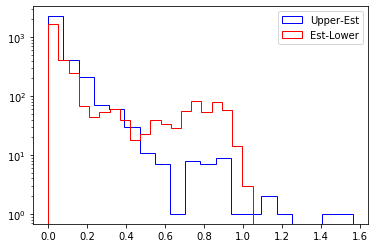

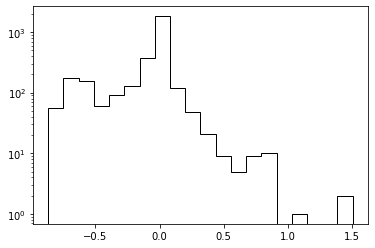

In [6]:
#Making The Histogram Anil wanted to see

log_masses=np.log10(M51_use['Best_Mass_Msolar'])
log_max_mass=np.log10(M51_use['Max_Mass_Msolar'])
log_min_mass=np.log10(M51_use['Min_Mass_Msolar'])

mass_error=[]
for i in range(len(log_max_mass)):
    mass_error.append((log_max_mass[i]-log_min_mass[i])/2)

plt.hist(log_max_mass-log_masses, color='b', histtype='step', bins=20, label='Upper-Est')
plt.hist(log_masses-log_min_mass, color='r', histtype='step', bins=20, label='Est-Lower')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist((log_max_mass-log_masses)-(log_masses-log_min_mass), color='k', histtype='step', bins=20)
#plt.hist(log_masses-log_min_mass, color='r', histtype='step', bins=20, label='Est-Lower')
plt.yscale('log')


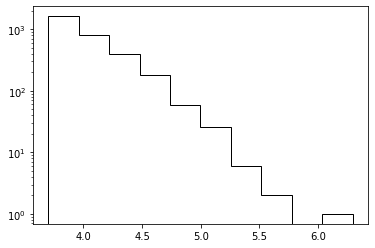

In [7]:
plt.hist(log_masses, histtype='step', color='k')
plt.yscale('log')

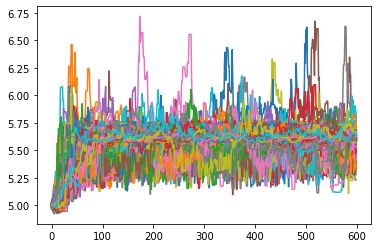

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


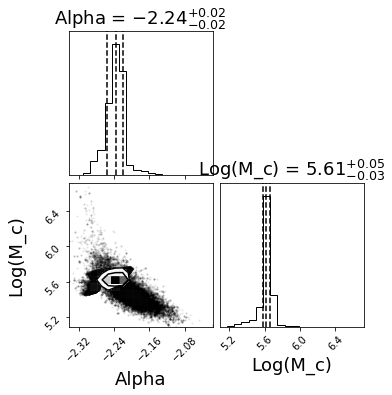

In [595]:
#Running their Sample

def lnZ(theta, M):
    alpha, M_c = theta
    lin_M_c= 10**M_c
    def f(M):
        return (M**alpha)*exp(-M/lin_M_c)
    ans, err = quad(f, 5000, np.inf)
    return np.log(ans)

def lnlike(theta, M):
    alpha, M_c = theta
    lin_M= 10**M
    lin_M_c= 10**M_c
    return (np.sum(-lin_M/lin_M_c + alpha*np.log(lin_M) - lnZ(theta, lin_M)))

def lnprior(theta):
    alpha, M_c = theta
    if -3 <= alpha <= -1 and 3 <= M_c <= 8:
        return 0.0
    return -np.inf

def lnprob(theta, M):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, M)

starting_point=np.array([-1.99, 5.00])

ndim, nwalkers = 2, 500
nsteps= 600
burnin=100
pos = starting_point + 1e-2*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=([log_masses]))
sampler.run_mcmc(pos, nsteps)

#plot chain
plt.plot(np.transpose(sampler.chain[:,:,1]))
plt.show()
sampler.get_chain(thin=5)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["Alpha", "Log(M_c)"], label_kwargs={"fontsize": 18},
                                     quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})

fig.show()

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


(array([3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056,
       3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067,
       3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078,
       3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089,
       3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100,
       3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111,
       3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122,
       3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133,
       3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144,
       3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155,
       3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166,
       3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177,
       3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187]),)
3103


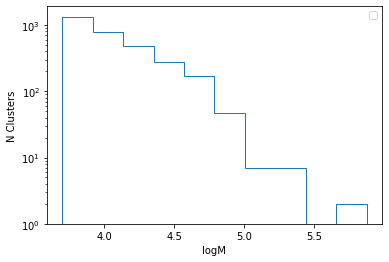

In [571]:
#Trying to generate randomn samples that follows a power law distribution with an upper mass truncation published 
#in Messa+2018

theoretical_distribution = powerlaw.Power_Law(xmin=5000, xmax=100000, parameters = [2], discrete=True)
simulated_data=theoretical_distribution.generate_random(3200)
fake_M_l=[]
for i in range(len(simulated_data)):
    fake_M_l.append(simulated_data[i])

A3_fml=[]
for i in range(len(fake_M_l)):
    if fake_M_l[i] >=5000 and fake_M_l[i] < 10**6.2:
        A3_fml.append(fake_M_l[i])
        
A3_fml.sort()

fake_M=np.array(A3_fml)
fake_M

print(np.where(fake_M>100000))

random_ints = np.array(random.sample(range(2991, 3200), 190))
#random_ints2 = np.array(random.sample(range(2940, 3180), 150))
new_fake_M=np.delete(fake_M, [random_ints])
#new_fake_M2=np.delete(new_fake_M, [random_ints2])

log_FMl=[3.7 for i in range(93)]
for i in range(len(new_fake_M)):
    log_FMl.append(np.log10(new_fake_M[i]))
    
log_FM= np.array(log_FMl)
log_FM
print(len(log_FM))


#x=[3,5.3]
#y=[461,1]
plt.hist(log_FM, histtype='step', bins=10)
#plt.plot(x,y, c='r', label='alpha= -2')
#plt.xlim(2.99,5)
plt.yscale('log')
plt.ylim(1)
plt.xlabel('logM')
plt.ylabel('N Clusters')
plt.legend()

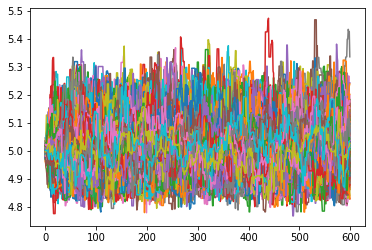

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


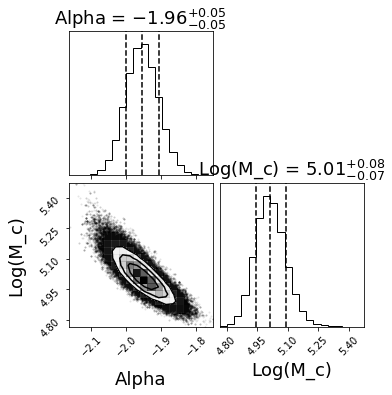

In [572]:
def lnZ(theta, M):
    alpha, M_c = theta
    lin_M_c= 10**M_c
    def f(M):
        return (M**alpha)*exp(-M/lin_M_c)
    ans, err = quad(f, 5000, np.inf)
    return np.log(ans)

def lnlike(theta, M):
    alpha, M_c = theta
    lin_M= 10**M
    lin_M_c= 10**M_c
    return (np.sum(-lin_M/lin_M_c + alpha*np.log(lin_M) - lnZ(theta, lin_M)))

def lnprior(theta):
    alpha, M_c = theta
    if -3 <= alpha <= -1 and 3 <= M_c <= 8:
        return 0.0
    return -np.inf

def lnprob(theta, M):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, M)

starting_point=np.array([-2.00, 5.00])

ndim, nwalkers = 2, 500
nsteps= 600
burnin=100
pos = starting_point + 1e-2*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=([log_FM]))
sampler.run_mcmc(pos, nsteps)

#plot chain
plt.plot(np.transpose(sampler.chain[:,:,1]))
plt.show()
sampler.get_chain(thin=5)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["Alpha", "Log(M_c)"], label_kwargs={"fontsize": 18},
                                     quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})

fig.show()

In [585]:
def uncertainty(mass_error, log_FM):
    spread_masses=[]
    for i in range(len(mass_error)):
        rand_spread=(np.random.normal(0, mass_error[i]))
        spread_masses.append(log_FM[i]+rand_spread)
    
    spread_masses=np.array(spread_masses)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=([spread_masses]))
    sampler.run_mcmc(pos, nsteps)

    #plot chain
#    plt.plot(np.transpose(sampler.chain[:,:,1]))
#    plt.show()
    sampler.get_chain(thin=5)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    fig = corner.corner(samples, labels=["Alpha", "Log(M_c)"], label_kwargs={"fontsize": 18},
                                     quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})
    
    fig.show()
    
    alpha=[i[0] for i in samples]
    Mc= [i[1] for i in samples]
    
    med_a=np.median(alpha)
    upper_sig_a= np.percentile(alpha, 84)  
    lower_sig_a= np.percentile(alpha, 16)
    med_Mc=np.median(Mc)
    upper_sig_Mc= np.percentile(Mc, 84)
    lower_sig_Mc= np.percentile(Mc, 16)
        
    return np.array((med_a, lower_sig_a, upper_sig_a, med_Mc, lower_sig_Mc, upper_sig_Mc))


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


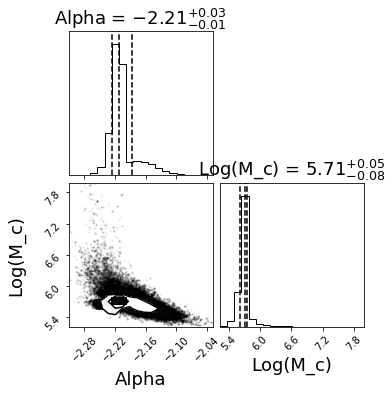

In [586]:
round1=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


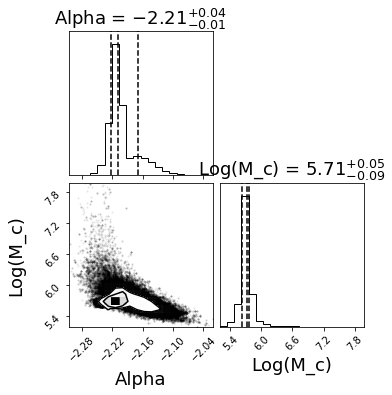

In [587]:
round2=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


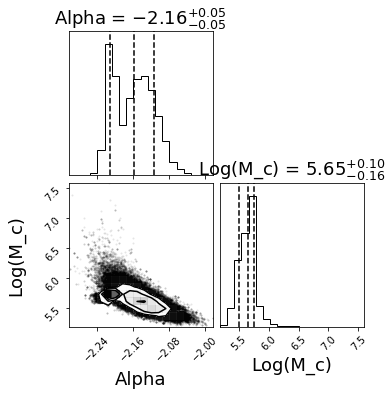

In [588]:
round3=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


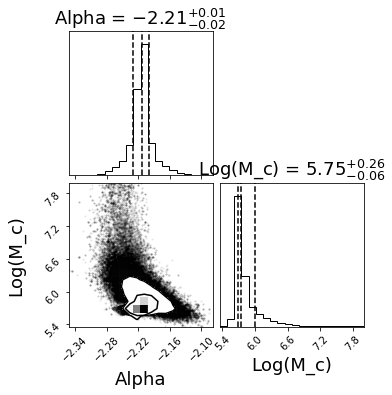

In [589]:
round4=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


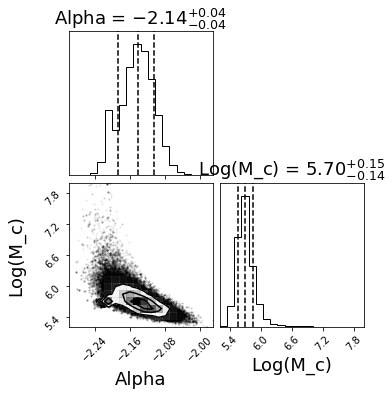

In [590]:
round5=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


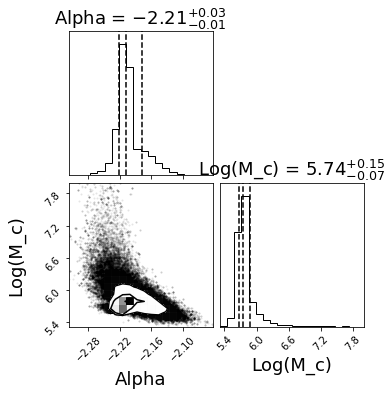

In [596]:
round6=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


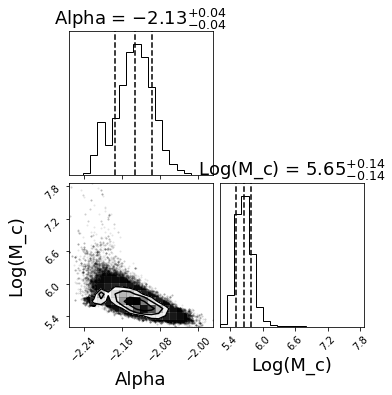

In [597]:
round7=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


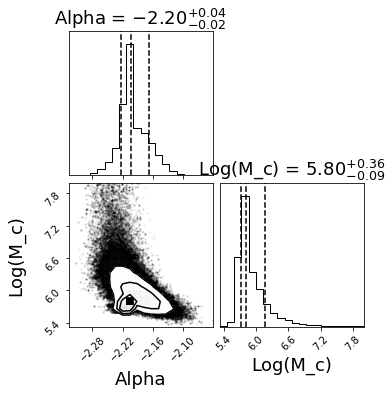

In [598]:
round8=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


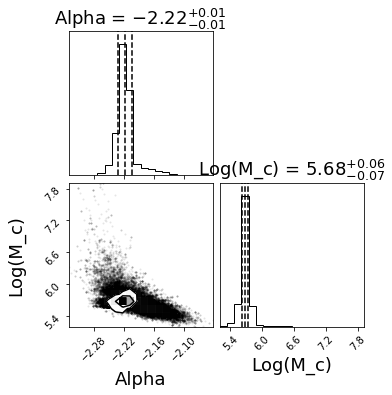

In [599]:
round9=uncertainty(mass_error, log_FM)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


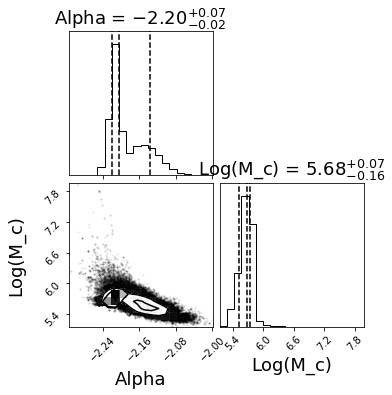

In [602]:
round10=uncertainty(mass_error, log_FM)

In [603]:
alphas=[round1[0], round2[0], round3[0], round4[0], round5[0], round6[0], round7[0], round8[0], round9[0], round10[0]]
Mcs= [round1[3], round2[3], round3[3], round4[3], round5[3], round6[3], round7[3], round8[3], round9[3], round10[3],]

print("Median:", np.median(Mcs))
print("1 Sigma:", np.percentile(Mcs, 16))
print("1 Sigma:", np.percentile(Mcs, 84))

Median: 5.701392119786052
1 Sigma: 5.6645783912585115
1 Sigma: 5.742840808132371
